In [96]:
import networkx as nx
import numpy as np
from dataclasses import dataclass, field
import pandas as pd
import json
from tqdm.notebook import trange, tqdm
from plotnine import ggplot, aes, geom_smooth, geom_point, xlab, ylab, geom_errorbar, geom_boxplot, geom_violin, scale_y_continuous
from collections import defaultdict

# Helper functions

In [2]:
@dataclass
class ResultSet:
    """
    Helper class to keep all results from a single experiment together
    """
    
    all_trails: np.array
    seed: np.array
    nuclei: np.array
    stations: np.array
    map_with_stations: np.array
    start_pos: np.array
    all_points: np.array = field(init=False)

    def __post_init__(self):
        points = self.nuclei.reshape(-1, 2)
        points = points[~np.all(points == 0, axis=1)]  # Remove zero points
        self.all_points = np.vstack([points, self.stations])

    def __str__(self):
        return f"Experiment with start pos {self.start_pos}, seed {self.seed}"

In [3]:
def find_shortest_paths(G, stations):
    paths = defaultdict(list) # list of shortest paths per source
    distances = defaultdict(dict) # (source, target)-dictionary with distances
        
    for i in range(len(stations)): # Loop over all source stations
        source = stations[i]
        for j in range(len(stations)): # Loop over all target stations
            if i == j: continue
            try:
                target = stations[j]
                length, path = nx.single_source_dijkstra(G, source=str(source), target=str(target), weight='weight')
                paths[source].append((length, path, target))
                distances[source][target] = length
            except nx.NetworkXNoPath:
                continue

    return paths, distances

In [4]:
def simplify_graph(G, stations):
    G_contracted = G.copy()
    non_removable = []
    
    # This evaluates to false when the set becomes empty
    while nodes_with_degree_2 := set([n for n, d in G_contracted.degree() if d == 2 
                                      and n not in stations
                                      and n not in non_removable]):
        node = nodes_with_degree_2.pop()
        edges = list(G_contracted.edges(node))
        left = edges[0][1]
        right = edges[1][1]
        if G_contracted.has_edge(left, right): # Edge already exists, cannot overwrite it
            non_removable.append(node)
            continue
        combined_weight = G_contracted[node][left]['weight'] + G_contracted[node][right]['weight']
        G_contracted.add_edge(left, right, weight = combined_weight)
        G_contracted.remove_node(node)

    return G_contracted

In [11]:
def calculate_network_cost(G):
    """
    Calculates the cost of the total network
    """
    return G.size('weight')

def calculate_mean_travel_time(G, stations):
    """
    Calculates the mean travel time on the network
    """
    _, distances = find_shortest_paths(G, stations)
    full_cost = calculate_network_cost(G)

    means = []
    for source in stations:
        target_distances = []
        for target in stations:
            if source == target: continue
            try:
                target_distance = distances[source][target]
            except KeyError:
                target_distance = full_cost
            target_distances.append(target_distance)

        means.append(np.mean(target_distances))
    return np.mean(means)
    
def calculate_network_vulnerability(G, ref_travel_time, stations):
    """
    Calculates the mean vulnerability on the network.
    If the graph becomes disconnected after an edge is removed,
    the vulnerability is then the weight of that edge.
    """
    vulnerabilities = []
    full_cost = calculate_network_cost(G)

    for e in tqdm(G.edges()):
        # Create a copy of the graph to avoid modifying the original
        G_copy = G.copy()
        G_copy.remove_edge(*e)
        
        mean_time = calculate_mean_travel_time(G_copy, stations)
        vuln = np.abs(ref_travel_time - mean_time)
        
        if not nx.is_connected(G_copy):
            vuln += full_cost
            
        vulnerabilities.append(vuln)
    return np.mean(vulnerabilities)

# Processing NS data

In [6]:
# Load datasets
ns_nodes = pd.read_csv('../distance-calculations/nodes.csv')
ns_edges = pd.read_csv('../distance-calculations/edges.csv')
station_coordinate_location_data = pd.read_csv('../distance-calculations/stations_of_interest.csv')
station_image_location_data = pd.read_csv('../distance-calculations/stations_in_output_json.csv')

# We need the conversion factor from coordinate space to image space
# we can use a least-squares approximation

joined_data = station_coordinate_location_data.join(station_image_location_data.set_index('code'), on='code')
coord_space_data = joined_data[['lat', 'lng']].to_numpy()
iamge_space_data = joined_data[['img_x', 'img_y']].to_numpy()

A, _, _, _ = np.linalg.lstsq(coord_space_data, iamge_space_data)

# Now, we can convert all stations to image space and use the same distance metric
img_space_df = pd.DataFrame(ns_nodes[['lat', 'lng']].to_numpy() @ A, columns=['img_x', 'img_y'])
ns_nodes_combined = pd.concat([ns_nodes.reset_index(drop = True), img_space_df], axis=1)

In [7]:
# First, we load the full NS graph
ns_graph = nx.Graph()

for _, edge in ns_edges.iterrows():
    from_node = ns_nodes_combined.query(f"name=='{edge['from']}'")[['img_x', 'img_y']].to_numpy()
    to_node = ns_nodes_combined.query(f"name=='{edge['to']}'")[['img_x', 'img_y']].to_numpy()

    dist = np.linalg.norm(from_node - to_node)
    ns_graph.add_edge(edge['from'], edge['to'], weight=dist)

In [8]:
# Then, we prune the edges that do not connect any stations in our final graph
# by taking the shortest path between all stations
# and only including edges in those paths
pruned_ns_graph = nx.Graph()

all_paths, distances = find_shortest_paths(ns_graph, joined_data['code'])
for source, paths in all_paths.items():
        paths = sorted(paths, key=lambda p: p[0])
        
        for length, path, target in paths:
            pruned_ns_graph.add_weighted_edges_from((str(path[k]), str(path[k+1]), ns_graph[path[k]][path[k+1]]['weight']) for k in range(len(path)-1))

edges = pd.DataFrame(pruned_ns_graph.edges(), columns=['from','to'])
edges.to_csv("../distance-calculations/edges_of_interest.csv", index=False)

In [12]:
# # Comparison of the total ns graph and the pruned ns graph
# ns_total_cost = ns_graph.size('weight')
# ns_mean_travel_time = calculate_mean_travel_time(distances)
# ns_network_vulnerability = calculate_network_vulnerability(ns_graph, ns_mean_travel_time, station_coordinate_location_data['code'])
# ns_is_connected = nx.is_connected(ns_graph)

# print("Full:")
# print(f"Total cost of the network: {ns_total_cost:.2f}")
# print(f"Mean travel time of the network: {ns_mean_travel_time:.2f}")
# print(f"Network vulnerability (mean increase in travel time with one edge removed): {ns_network_vulnerability:.2f}")
# print(f"Network is {"connected" if ns_is_connected else "not connected"}")

# ns_total_cost = pruned_ns_graph.size('weight')
# ns_mean_travel_time = calculate_mean_travel_time(distances)
# ns_network_vulnerability = calculate_network_vulnerability(ns_graph, ns_mean_travel_time, station_coordinate_location_data['code'])
# ns_is_connected = nx.is_connected(pruned_ns_graph)

# print("Pruned:")
# print(f"Total cost of the network: {ns_total_cost:.2f}")
# print(f"Mean travel time of the network: {ns_mean_travel_time:.2f}")
# print(f"Network vulnerability (mean increase in travel time with one edge removed): {ns_network_vulnerability:.2f}")
# print(f"Network is {"connected" if ns_is_connected else "not connected"}")

stations = list(station_coordinate_location_data['code'])
simple_ns_graph = simplify_graph(pruned_ns_graph, stations)
ns_total_cost = calculate_network_cost(simple_ns_graph)
ns_mean_travel_time = calculate_mean_travel_time(simple_ns_graph, stations)
ns_network_vulnerability = calculate_network_vulnerability(ns_graph, ns_mean_travel_time, stations)
ns_is_connected = nx.is_connected(ns_graph)

print("Simple:")
print(f"Total cost of the network: {ns_total_cost:.2f}")
print(f"Mean travel time of the network: {ns_mean_travel_time:.2f}")
print(f"Network vulnerability (mean increase in travel time with one edge removed): {ns_network_vulnerability:.2f}")
print(f"Network is {"connected" if ns_is_connected else "not connected"}")

  0%|          | 0/434 [00:00<?, ?it/s]

Simple:
Total cost of the network: 5004.32
Mean travel time of the network: 283.89
Network vulnerability (mean increase in travel time with one edge removed): 1287.57
Network is connected


# Load and process data frames

In [13]:
proximities = range(1, 6)

different_starts = pd.DataFrame()
for proximity in proximities:
    df = pd.read_csv('../experiment_outputs_different_starts/results.csv')
    different_starts = pd.concat([different_starts, df], ignore_index=True, sort=False)
different_starts = different_starts.drop('Unnamed: 0', axis=1) # Drop old index column

same_starts = pd.DataFrame()
for proximity in proximities:
    df = pd.read_csv('../experiment_outputs_same_starts/results.csv')
    same_starts = pd.concat([same_starts, df], ignore_index=True, sort=False)
same_starts = same_starts.drop('Unnamed: 0', axis=1)

In [14]:
different_starts

,proximity,start_pos_x,start_pos_y,seed,total_cost,mean_travel_time,vulnerability,is_connected
0,1,444,601,6,2044.451127,1870.143480,2104.872749,False
1,2,444,601,6,4608.422106,2311.322168,4749.621200,False
2,3,444,601,6,6854.300256,437.639857,265.444442,True
3,4,444,601,6,9111.368602,408.854968,181.875704,True
4,5,444,601,6,11848.961631,396.155042,153.559555,True
...,...,...,...,...,...,...,...,...
645,1,692,468,15,2064.639278,1888.506110,2129.780430,False
646,2,692,468,15,4475.087944,2733.683329,4571.946369,False
647,3,692,468,15,6779.377955,448.932350,487.854735,True
648,4,692,468,15,9224.579269,405.401960,242.111588,True


In [15]:
same_starts

,proximity,start_pos_x,start_pos_y,seed,total_cost,mean_travel_time,vulnerability,is_connected
0,1,482,413,6,2039.590470,1865.601964,2096.792367,False
1,2,482,413,6,4456.276161,2202.512420,4595.495728,False
2,3,482,413,6,6654.405681,452.627095,639.688839,True
3,4,482,413,6,9196.290900,406.709112,412.071776,True
4,5,482,413,6,12365.387846,390.973337,345.865371,True
...,...,...,...,...,...,...,...,...
545,1,482,413,15,2062.427602,1886.589596,2123.512808,False
546,2,482,413,15,4425.856490,3368.271078,4491.001159,False
547,3,482,413,15,6766.698885,456.747992,643.039013,True
548,4,482,413,15,9825.566150,407.813957,314.878367,True


## Processing different starts

In [16]:
max_cost_different_starts = different_starts['total_cost'].max()
max_travel_time_different_starts = different_starts['mean_travel_time'].max()
max_vulnerability_different_starts = different_starts['vulnerability'].max()

different_starts = different_starts.assign(
    norm_cost = lambda df: df['total_cost'] / max_cost_different_starts
).assign(
    norm_travel_time = lambda df: df['mean_travel_time'] / max_travel_time_different_starts
).assign(
    norm_vulnerability = lambda df: df['vulnerability'] / max_vulnerability_different_starts
)

means_per_proximity_different_starts = different_starts.groupby('proximity', as_index=False).mean()[['proximity', 'norm_cost', 'norm_travel_time', 'norm_vulnerability']]

ns_different_starts = pd.DataFrame({
    'norm_cost': [ns_total_cost / max_cost_different_starts],
    'norm_travel_time':  [ns_mean_travel_time / max_travel_time_different_starts],
    'norm_vulnerability': [ns_network_vulnerability / max_vulnerability_different_starts]
})

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


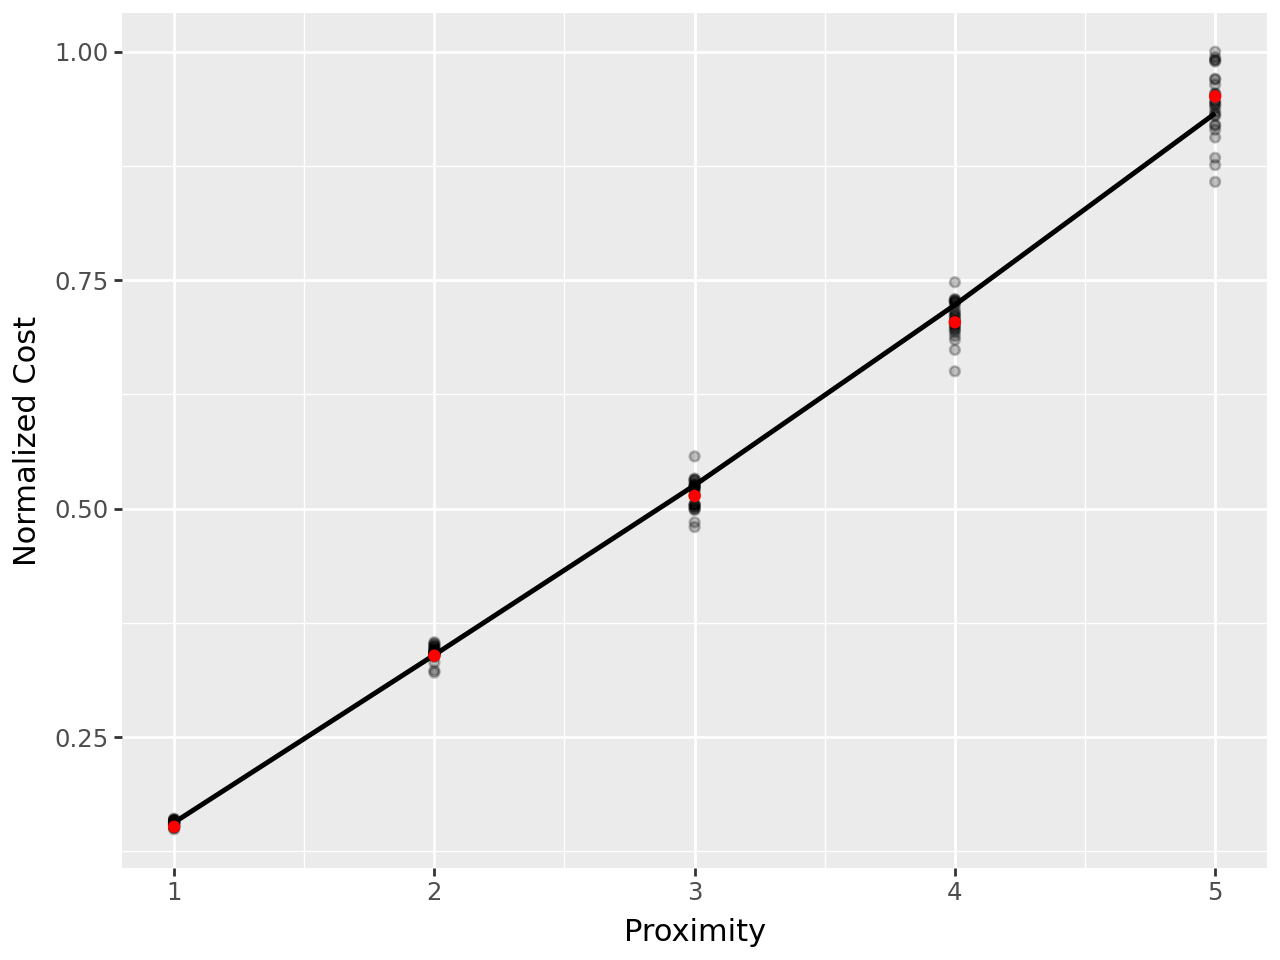

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: different_starts_proximity_norm_cost.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [68]:
p =(
    ggplot(different_starts) + 
    aes(x='proximity', y='norm_cost') + 
    geom_point(alpha=0.05) +
    geom_smooth() +
    geom_point(data=means_per_proximity_same_starts, color='red') +
    xlab("Proximity") +
    ylab("Normalized Cost")
)

p.show()
p.save("different_starts_proximity_norm_cost.png")

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


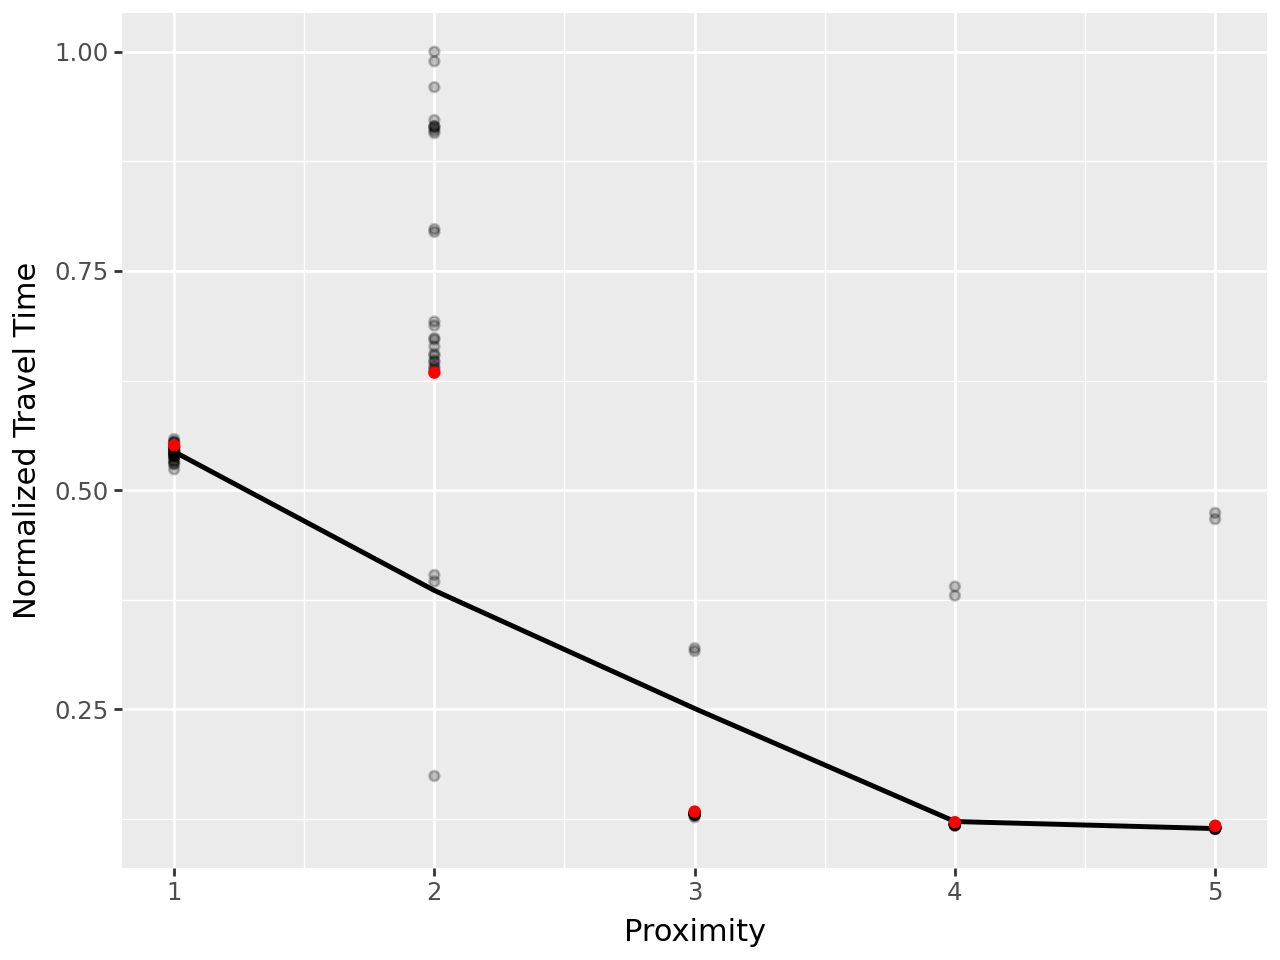

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: different_starts_proximity_norm_travel_time.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [69]:
p= (
    ggplot(different_starts) + 
    aes(x='proximity', y='norm_travel_time') + 
    geom_point(alpha=0.05) +
    geom_smooth() +
    geom_point(data=means_per_proximity_same_starts, color='red') +
    xlab("Proximity") +
    ylab("Normalized Travel Time")
)

p.show()
p.save("different_starts_proximity_norm_travel_time.png")

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


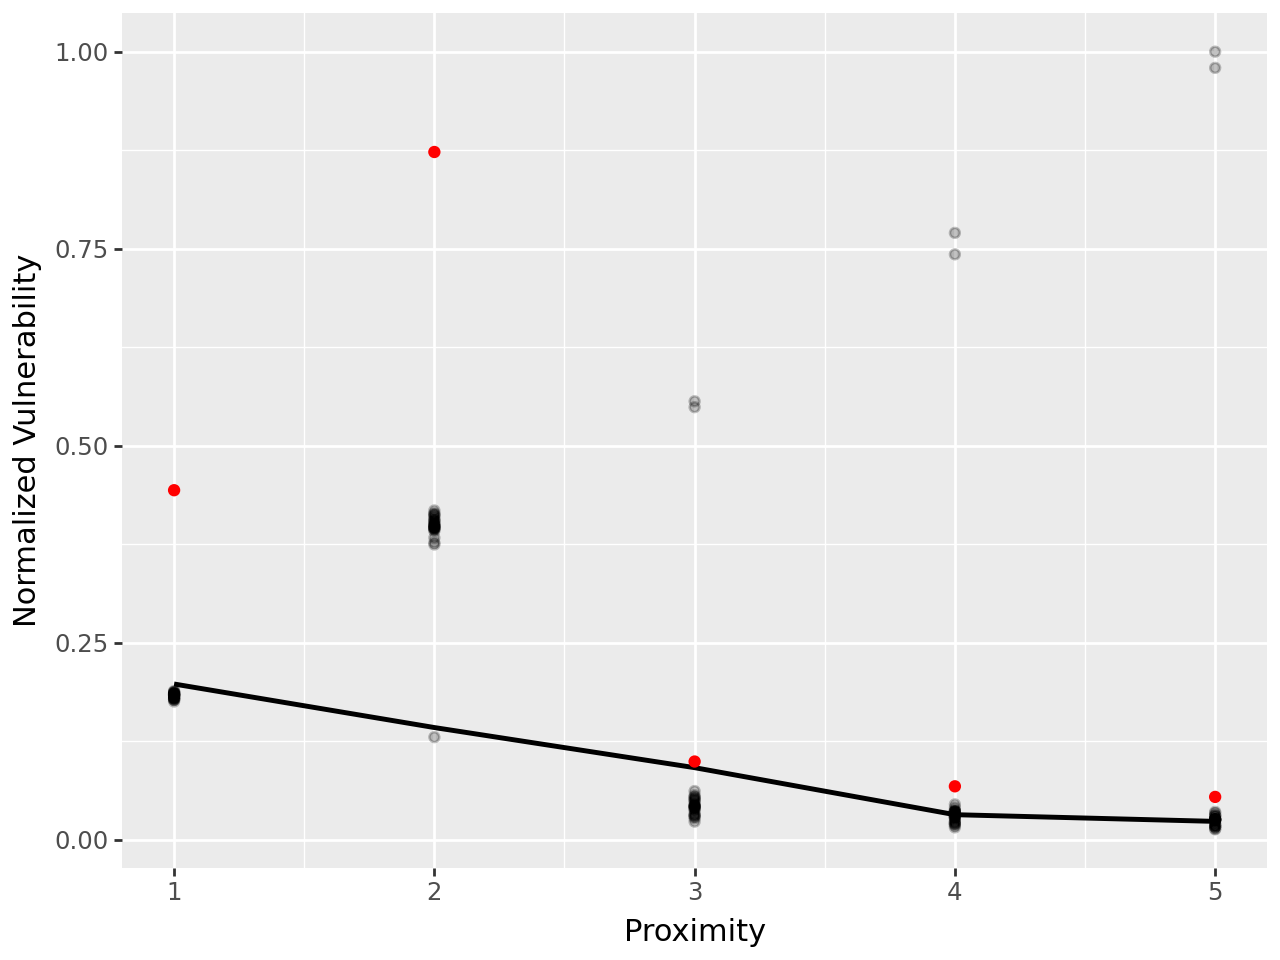

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: different_starts_proximity_norm_vulnerability.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [70]:
p = (
    ggplot(different_starts) + 
    aes(x='proximity', y='norm_vulnerability') + 
    geom_point(alpha=0.05) +
    geom_smooth() +
    geom_point(data=means_per_proximity_same_starts, color='red') +
    xlab("Proximity") +
    ylab("Normalized Vulnerability")
)

p.show()
p.save("different_starts_proximity_norm_vulnerability.png")

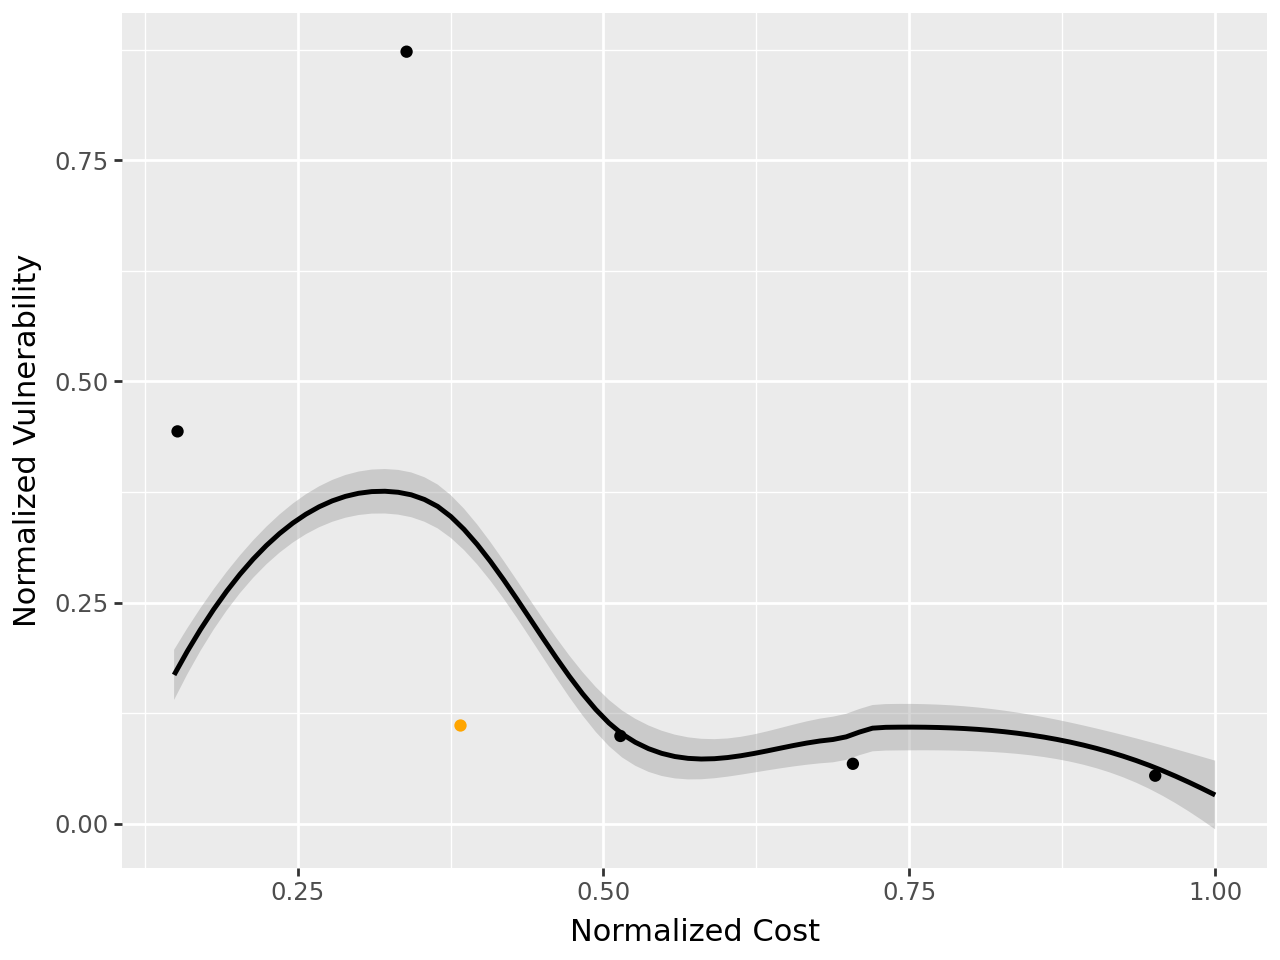

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: different_starts_norm_cost_norm_vulnerability.png


In [92]:
p = (
    ggplot(different_starts) + 
    aes(x='norm_cost', y='norm_vulnerability') + 
    geom_smooth(method='loess') +
    geom_point(data=means_per_proximity_same_starts) +
    geom_point(data=ns_different_starts, color='orange') +
    xlab("Normalized Cost") +
    ylab("Normalized Vulnerability")
)

p.show()
p.save("different_starts_norm_cost_norm_vulnerability.png")

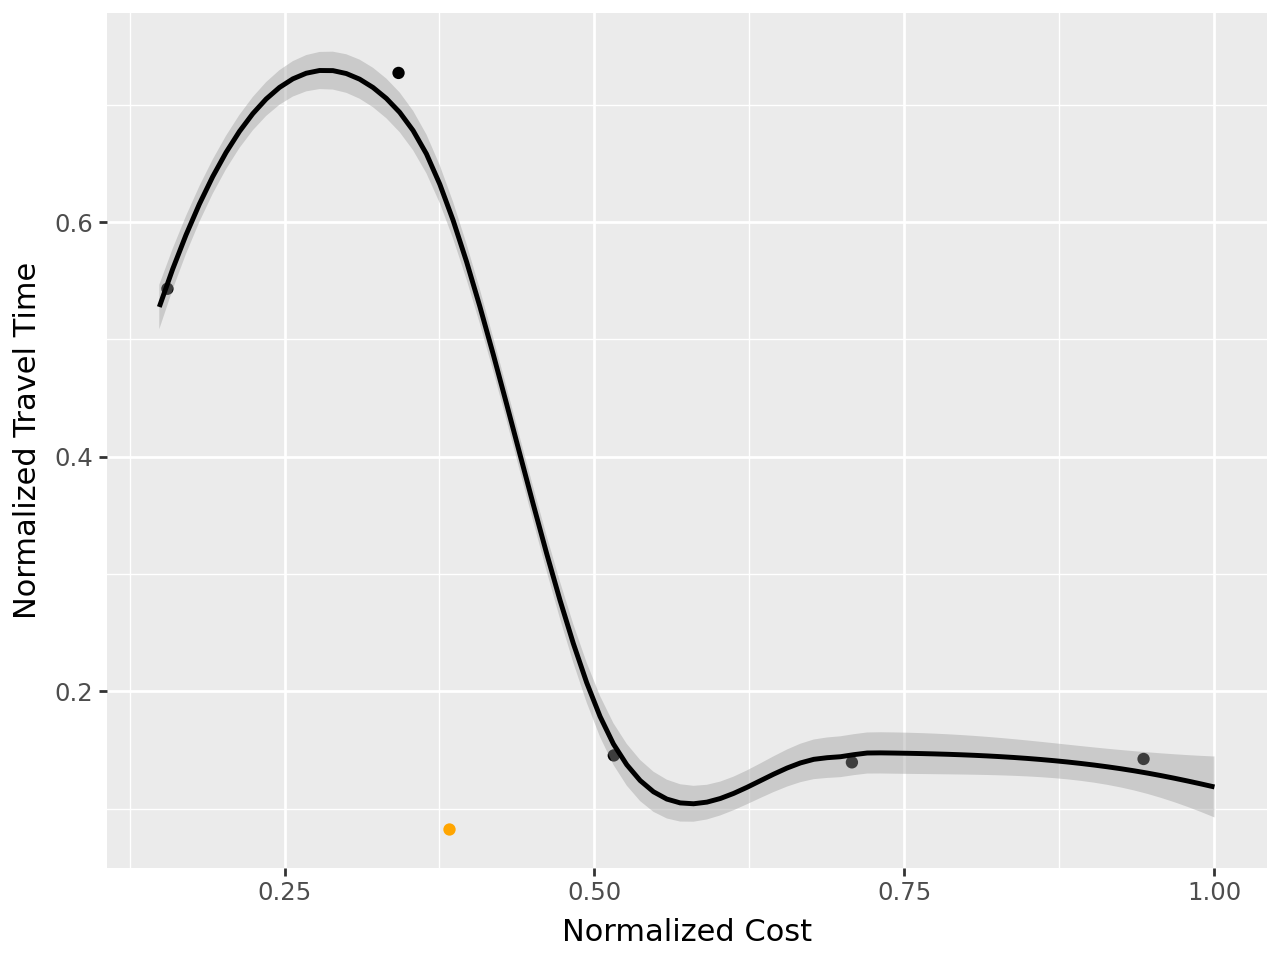

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: different_starts_norm_cost_norm_travel_time.png


In [91]:
p = (
    ggplot(different_starts) + 
    aes(x='norm_cost', y='norm_travel_time') + 
    geom_point(data=means_per_proximity_different_starts) + 
    geom_smooth(method='loess') +
    geom_point(data=ns_different_starts, color='orange') +
    xlab("Normalized Cost") +
    ylab("Normalized Travel Time")
)

p.show()
p.save("different_starts_norm_cost_norm_travel_time.png")

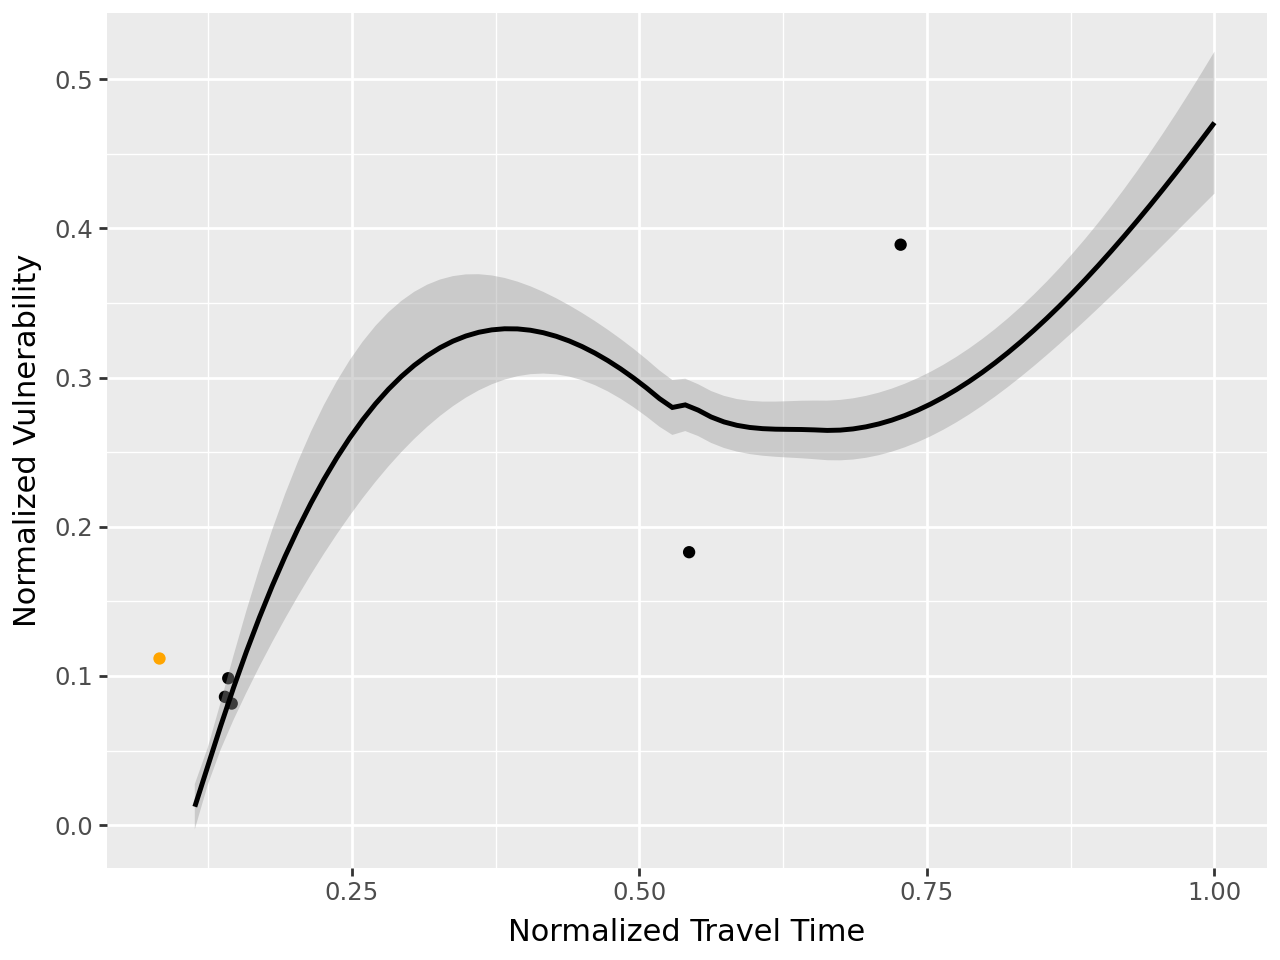

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: different_starts_norm_travel_time_norm_vulnerability.png


In [103]:
p = (
    ggplot(different_starts) + 
    aes(x='norm_travel_time', y='norm_vulnerability') + 
    geom_point(data=means_per_proximity_different_starts) + 
    # geom_smooth(method='glm', formula='y ~ np.exp(x)') +
    geom_smooth(method='loess') +
    geom_point(data=ns_different_starts, color='orange') +
    xlab("Normalized Travel Time") +
    ylab("Normalized Vulnerability")
)

p.show()
p.save("different_starts_norm_travel_time_norm_vulnerability.png")

## Processing same start

In [23]:
max_cost_same_starts = same_starts['total_cost'].max()
max_travel_time_same_starts = same_starts['mean_travel_time'].max()
max_vulnerability_same_starts = same_starts['vulnerability'].max()

same_starts = same_starts.assign(
    norm_cost = lambda df: df['total_cost'] / max_cost_same_starts,
).assign(
    norm_travel_time = lambda df: df['mean_travel_time'] / max_travel_time_same_starts
).assign(
    norm_vulnerability = lambda df: df['vulnerability'] / max_vulnerability_same_starts
)

means_per_proximity_same_starts = same_starts.groupby('proximity', as_index=False).mean()[['proximity', 'norm_cost', 'norm_travel_time', 'norm_vulnerability']]

ns_same_starts = pd.DataFrame({
    'norm_cost': [ns_total_cost / max_cost_same_starts],
    'norm_travel_time':  [ns_mean_travel_time / max_travel_time_same_starts],
    'norm_vulnerability': [ns_network_vulnerability / max_vulnerability_same_starts]
})

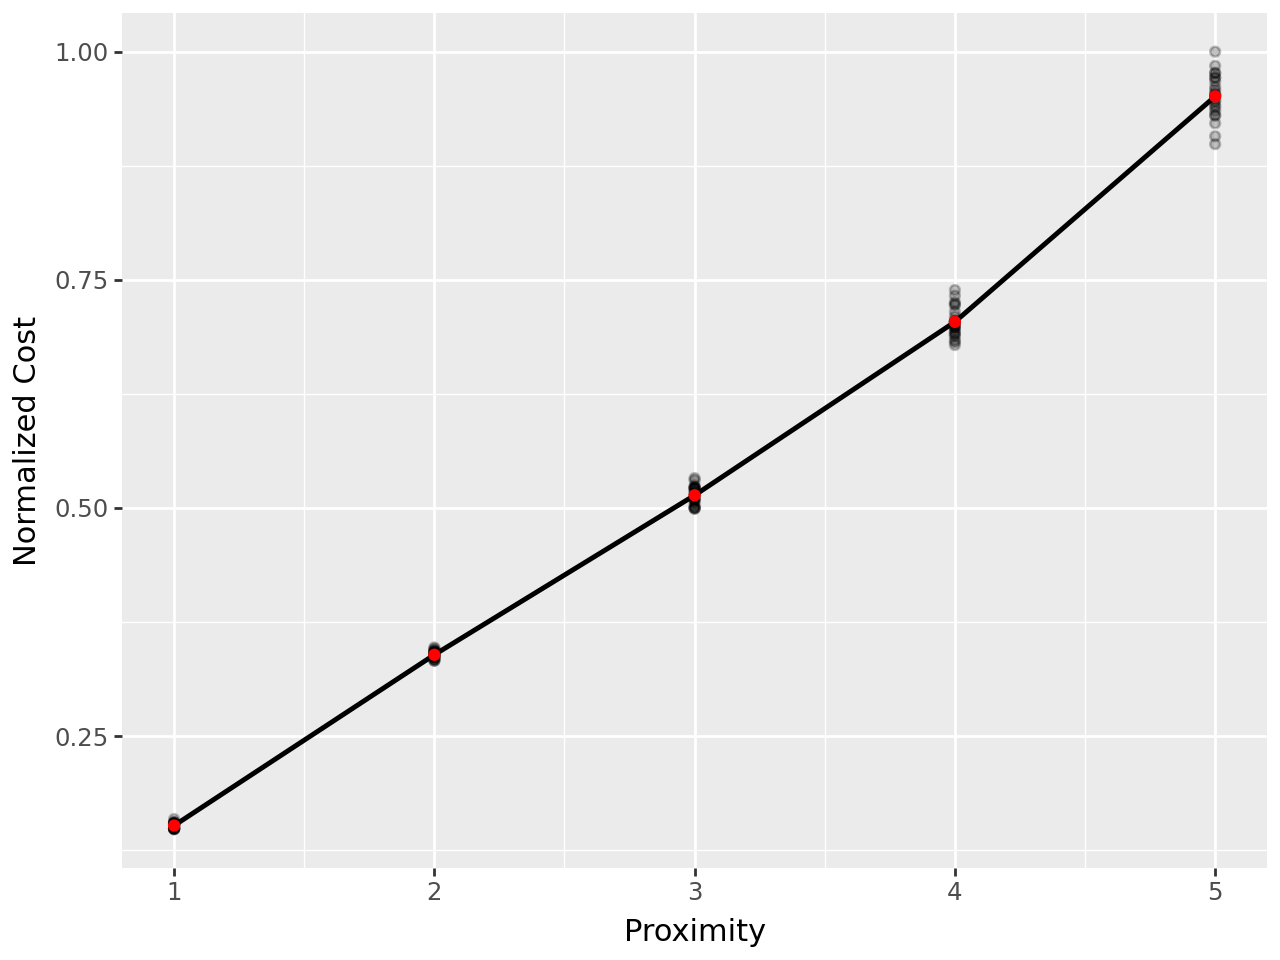

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: same_starts_proximity_norm_cost.png


In [89]:
p = (
    ggplot(same_starts) + 
    aes(x='proximity', y='norm_cost') + 
    geom_point(alpha=0.05) +
    geom_smooth(method='loess', se=False) +
    geom_point(data=means_per_proximity_same_starts, color='red') +
    xlab("Proximity") +
    ylab("Normalized Cost")
)

p.show()
p.save("same_starts_proximity_norm_cost.png")

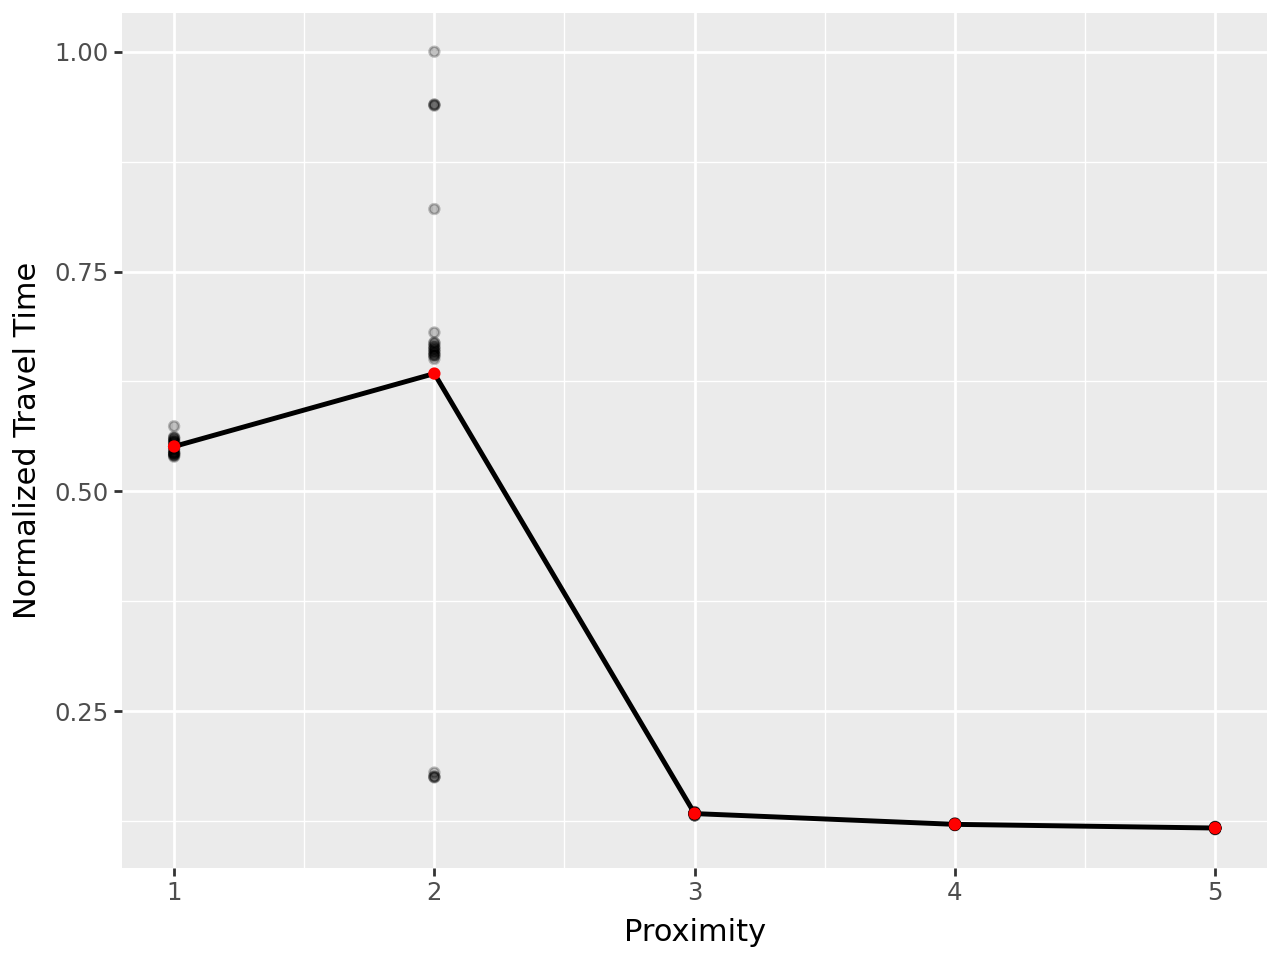

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: same_starts_proximity_norm_travel_time.png


In [88]:
p = (
    ggplot(same_starts) + 
    aes(x='proximity', y='norm_travel_time') + 
    geom_point(alpha=0.05) +
    geom_smooth(method='loess', se=False) +
    geom_point(data=means_per_proximity_same_starts, color='red') +
    xlab("Proximity") +
    ylab("Normalized Travel Time")
)

p.show()
p.save("same_starts_proximity_norm_travel_time.png")

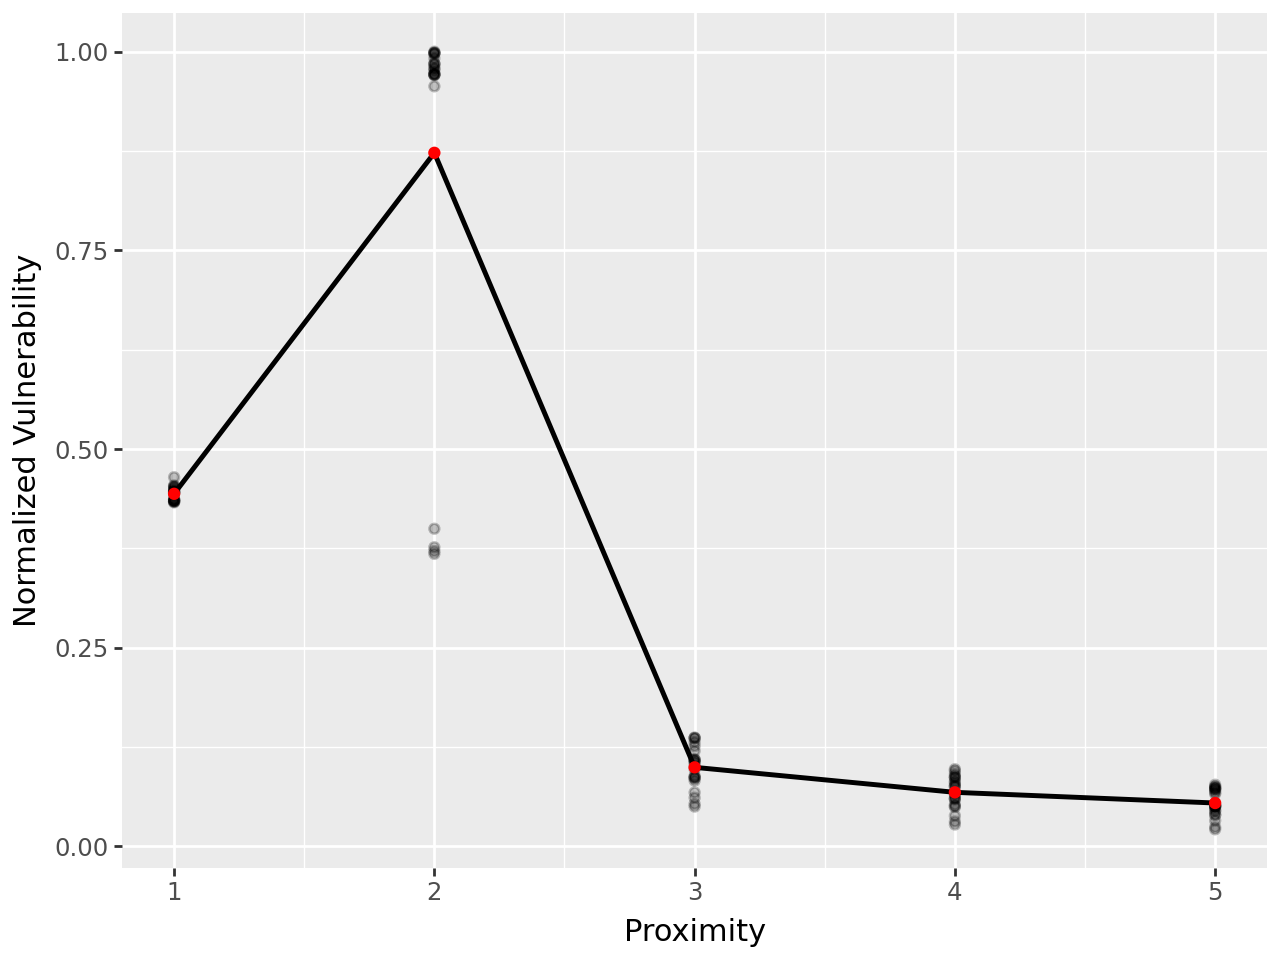

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: same_starts_proximity_norm_vulnerability.png


In [86]:
p = (
    ggplot(same_starts) + 
    aes(x='proximity', y='norm_vulnerability') +  
    geom_point(alpha=0.05) +
    geom_smooth(method='loess', se=False) +
    geom_point(data=means_per_proximity_same_starts, color='red') +
    xlab("Proximity") +
    ylab("Normalized Vulnerability")
)

p.show()
p.save("same_starts_proximity_norm_vulnerability.png")

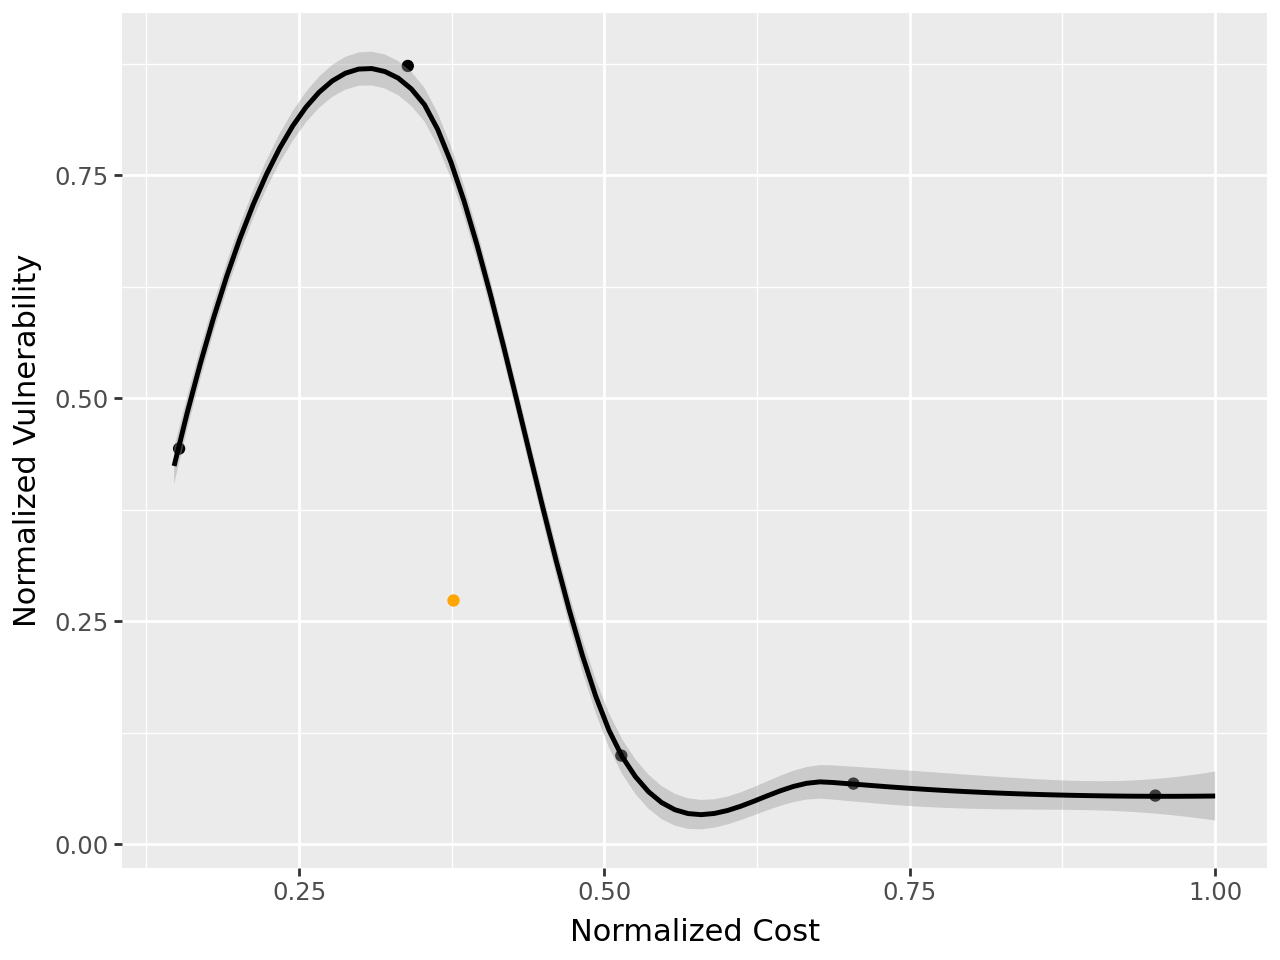

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: same_starts_norm_cost_norm_vulnerability.png


In [84]:
p = (
    ggplot(same_starts) + 
    aes(x='norm_cost', y='norm_vulnerability') + 
    geom_point(data=means_per_proximity_same_starts) + 
    geom_smooth(method='loess') +
    geom_point(data=ns_same_starts, color='orange') +
    xlab("Normalized Cost") +
    ylab("Normalized Vulnerability")
)

p.show()
p.save("same_starts_norm_cost_norm_vulnerability.png")

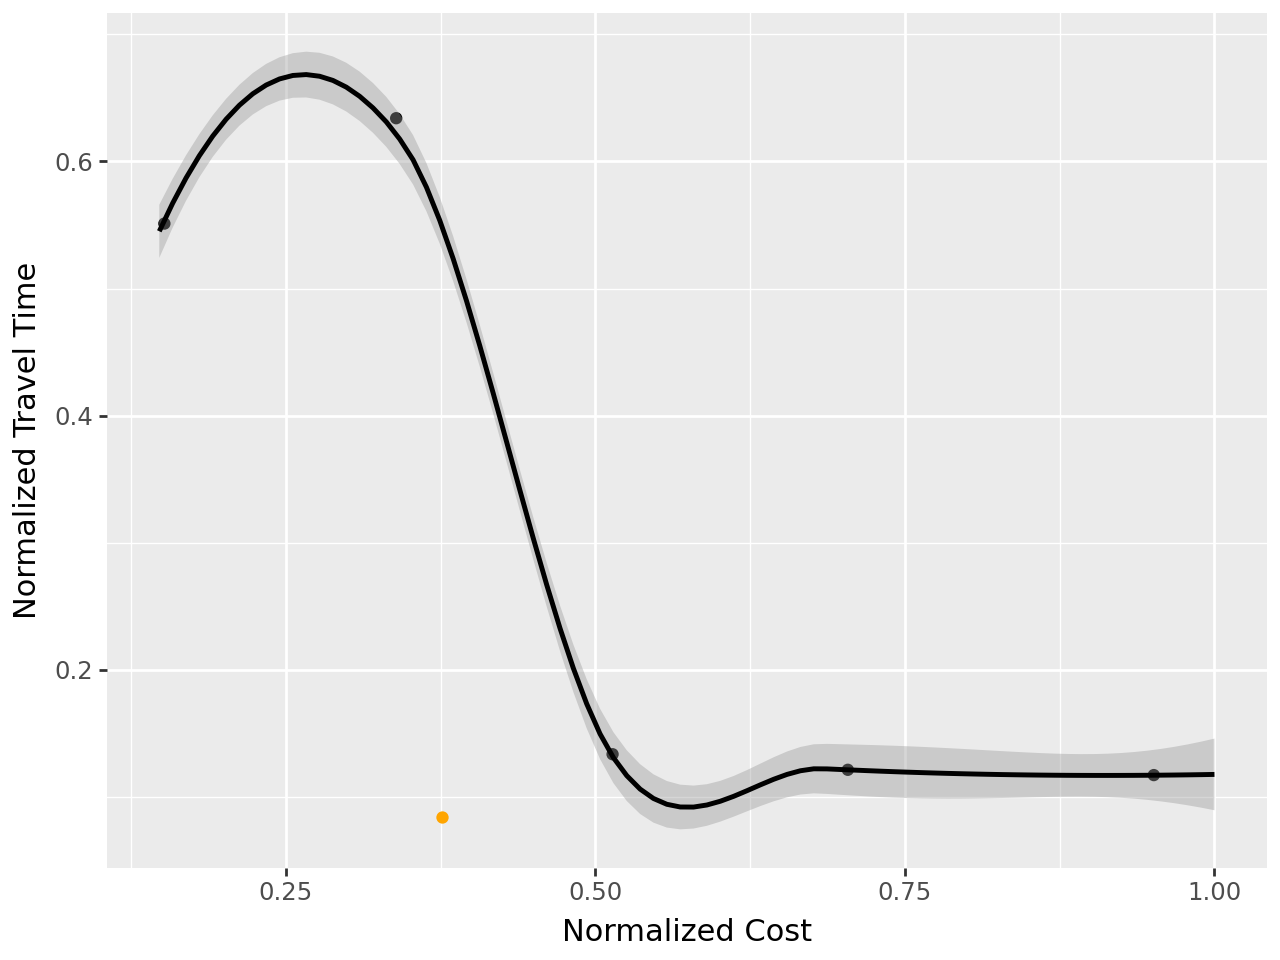

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: same_starts_norm_cost_norm_travel_time.png


In [83]:
p = (
    ggplot(same_starts) + 
    aes(x='norm_cost', y='norm_travel_time') + 
    geom_point(data=means_per_proximity_same_starts) + 
    geom_smooth(method='loess') +
    geom_point(data=ns_same_starts, color='orange') +
    xlab("Normalized Cost") +
    ylab("Normalized Travel Time")
)

p.show()
p.save("same_starts_norm_cost_norm_travel_time.png")

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_smooth : Removed 15 rows containing missing values.


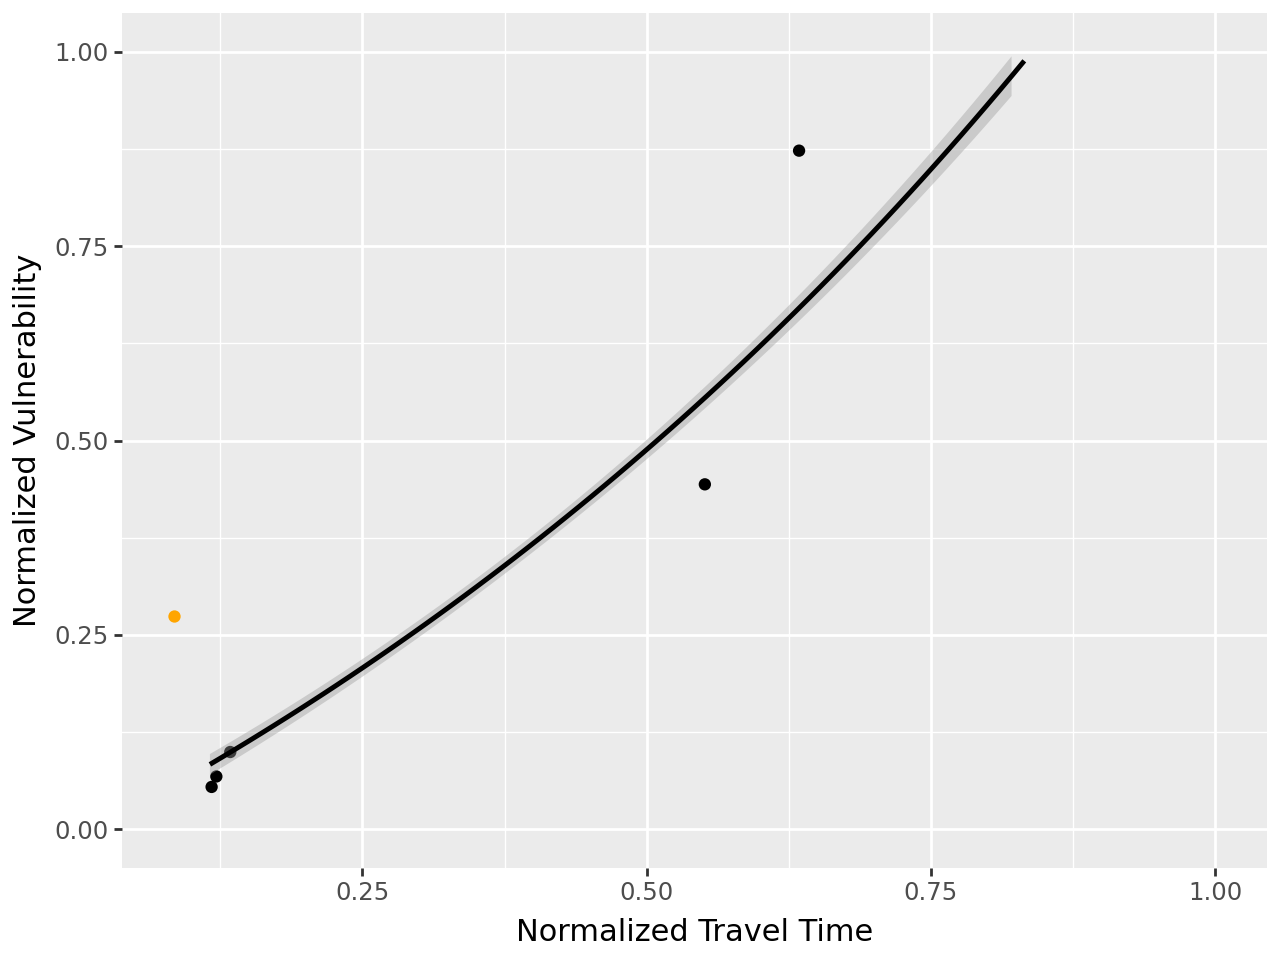

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: same_starts_norm_travel_time_norm_vulnerability.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_smooth : Removed 15 rows containing missing values.


In [99]:
p = (
    ggplot(same_starts) + 
    aes(x='norm_travel_time', y='norm_vulnerability') + 
    geom_point(data=means_per_proximity_same_starts) + 
    geom_smooth(method='glm', formula='y ~ np.exp(x)') +
    geom_point(data=ns_same_starts, color='orange') +
    xlab("Normalized Travel Time") +
    ylab("Normalized Vulnerability") +
    scale_y_continuous(limits=(0,1)) +
)

p.show()
p.save("same_starts_norm_travel_time_norm_vulnerability.png")